This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [0]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

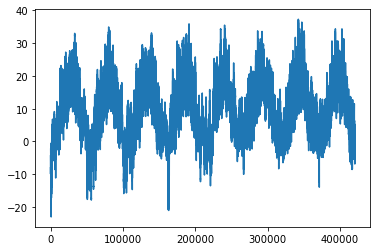

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

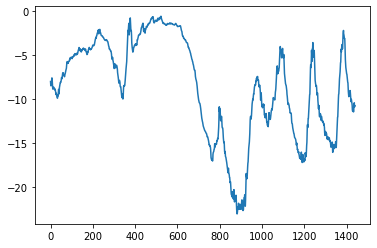

In [4]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 6s 6ms/step - loss: 12.6572 - mae: 2.7477 - val_loss: 11.3838 - val_mae: 2.6549
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 9.0960 - mae: 2.3711 - val_loss: 9.8224 - val_mae: 2.4633
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 8.2734 - mae: 2.2656 - val_loss: 12.5271 - val_mae: 2.8009
Epoch 4/10
819/819 [==============================] - 5s 6ms/step - loss: 7.8064 - mae: 2.2059 - val_loss: 10.3681 - val_mae: 2.5442
Epoch 5/10
819/819 [==============================] - 5s 6ms/step - loss: 7.4812 - mae: 2.1629 - val_loss: 11.4768 - val_mae: 2.6764
Epoch 6/10
819/819 [==============================] - 5s 6ms/step - loss: 7.2546 - mae: 2.1293 - val_loss: 10.5296 - val_mae: 2.5616
Epoch 7/10
819/819 [==============================] - 5s 6ms/step - loss: 7.0873 - mae: 2.1059 - val_loss: 10.5754 - val_mae: 2.5686
Epoch 8/10
819/819 [==============================] - 5s 6ms/step - l

**Plotting results**

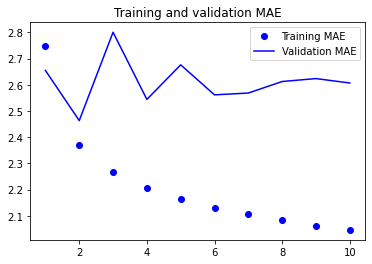

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 9ms/step - loss: 24.3670 - mae: 3.8371 - val_loss: 15.6560 - val_mae: 3.1207
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 15.7505 - mae: 3.1497 - val_loss: 18.1392 - val_mae: 3.3539
Epoch 3/10
819/819 [==============================] - 9s 10ms/step - loss: 14.4414 - mae: 3.0116 - val_loss: 14.8862 - val_mae: 3.0594
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 13.6781 - mae: 2.9235 - val_loss: 16.0429 - val_mae: 3.1482
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 13.1143 - mae: 2.8607 - val_loss: 17.8093 - val_mae: 3.3372
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 12.6263 - mae: 2.8090 - val_loss: 15.4455 - val_mae: 3.0965
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 12.2076 - mae: 2.7621 - val_loss: 16.6135 - val_mae: 3.1888
Epoch 8/10
819/819 [==============================] - 9s

### A first recurrent baseline

**A simple LSTM-based model**

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 11ms/step - loss: 41.6994 - mae: 4.6888 - val_loss: 12.3566 - val_mae: 2.6717
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 10.9468 - mae: 2.5680 - val_loss: 9.8223 - val_mae: 2.4259
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 9.8583 - mae: 2.4479 - val_loss: 10.0782 - val_mae: 2.4494
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 9.5077 - mae: 2.3999 - val_loss: 9.9815 - val_mae: 2.4336
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 9.2706 - mae: 2.3689 - val_loss: 10.3790 - val_mae: 2.4633
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 9.0969 - mae: 2.3448 - val_loss: 10.4309 - val_mae: 2.4690
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 8.8533 - mae: 2.3102 - val_loss: 10.0912 - val_mae: 2.4289
Epoch 8/10
819/819 [==============================] - 9s 11ms

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [15]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [16]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [17]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [19]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 502s 611ms/step - loss: 26.0826 - mae: 3.7911 - val_loss: 10.0547 - val_mae: 2.4713
Epoch 2/50
819/819 [==============================] - 508s 620ms/step - loss: 14.7710 - mae: 2.9846 - val_loss: 9.3839 - val_mae: 2.3778
Epoch 3/50
819/819 [==============================] - 479s 585ms/step - loss: 13.8350 - mae: 2.8839 - val_loss: 9.4168 - val_mae: 2.3872
Epoch 4/50
819/819 [==============================] - 482s 589ms/step - loss: 13.1707 - mae: 2.8115 - val_loss: 9.5503 - val_mae: 2.4078
Epoch 5/50
819/819 [==============================] - 530s 647ms/step - loss: 12.7362 - mae: 2.7667 - val_loss: 9.3157 - val_mae: 2.3709
Epoch 6/50
819/819 [==============================] - 549s 670ms/step - loss: 12.3723 - mae: 2.7239 - val_loss: 9.5854 - val_mae: 2.4084
Epoch 7/50
819/819 [==============================] - 552s 674ms/step - loss: 12.1062 - mae: 2.6944 - val_loss: 9.6112 - val_mae: 2.4133
Epoch 8/50
819/819 [====================

KeyboardInterrupt: 

In [21]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
106/819 [==>...........................] - ETA: 12:14 - loss: 57.7047 - mae: 5.8984

KeyboardInterrupt: 

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 15s 16ms/step - loss: 22.8377 - mae: 3.4853 - val_loss: 10.5646 - val_mae: 2.5131
Epoch 2/5
819/819 [==============================] - 13s 16ms/step - loss: 9.4007 - mae: 2.3916 - val_loss: 10.1300 - val_mae: 2.4671
Epoch 3/5
819/819 [==============================] - 13s 16ms/step - loss: 8.4834 - mae: 2.2660 - val_loss: 11.2669 - val_mae: 2.5690
Epoch 4/5
819/819 [==============================] - 13s 16ms/step - loss: 8.0228 - mae: 2.2049 - val_loss: 10.4065 - val_mae: 2.4891
Epoch 5/5
819/819 [==============================] - 13s 16ms/step - loss: 7.6331 - mae: 2.1498 - val_loss: 11.1995 - val_mae: 2.5748


### Going even further

## Summary